# Movies Dataset Processing & Analysis

![Movies Image](plugins/assets/movies_image.png)

### Objective:
The aim of this project is to fetch historical data about movies metadata from open APIs. The gathered data will be processed, cleaned, then will be stored in the data lake using AWS S3, loaded into Snowflake, and Visualize through dashboard. 

The [Kaggle Movies Dataset](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data) that used contains metadata for all 45,000 movies listed in the Full MovieLens Dataset. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

This dataset also has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

## Key Features of the Project:

### Data Collection:
Identify reliable open sources for movies dataset.
Use Python to fetch data using libraries such as requests, pandas, or openpyxl.


### Data Processing:
Clean and preprocess the data to ensure it's in a usable format.
Handle missing data, duplicates, and irrelevant columns.
Perform any necessary transformations (e.g., from json to dataset).

### Data Storage:
Store the data into the data lake (e.g., AWS S3) then load the data from data lake into data warehouse(e.g., Google BigQuery, AWS Redshift) for later use.


### Dashboard Development:
Use a Python visualization library (e.g., Plotly, Dash, Matplotlib) to build an interactive dashboard.
The dashboard will allow users to interact with data, filter by transport type, and visualize transport routes, schedules, or other metrics.


### Experimentation & Analysis:
Experiment with data fetching, transformation, and the integration of APIs.
Explore possible analyses such as peak-hour transport usage, performance (on-time arrivals), and comparison across routes.

### Load Libraries:

In [195]:
# Import all necessary packages
import pandas as pd
import numpy as np
import plugins.utils as utils
import snowflake.connector
from plugins.config import snow_creds, aws_creds
import json
from typing import Optional
import ast

## Data Collection:

In [196]:
# Download the dataset from Kaggle
dataset_name = "rounakbanik/the-movies-dataset" 
download_folder = "./plugins/assets/data/the-movies-dataset"
utils.download_kaggle_dataset(dataset_name, download_folder)

Folder './plugins/assets/data/the-movies-dataset' has been filled.


In [197]:
# Load all of the data into DataFrames
# The column ID -> identifier will be distinguished by using m_id which stands for movie_id (Most likely to be tmdbId in links df)
credits = pd.read_csv("./plugins/assets/data/the-movies-dataset/credits.csv")
keywords = pd.read_csv("./plugins/assets/data/the-movies-dataset/keywords.csv")
links = pd.read_csv("./plugins/assets/data/the-movies-dataset/links.csv")
movies_metadata = pd.read_csv("./plugins/assets/data/the-movies-dataset/movies_metadata.csv")
ratings = pd.read_csv("./plugins/assets/data/the-movies-dataset/ratings.csv")

C:\Users\iqbal\AppData\Local\Temp\ipykernel_18776\4206996445.py:6: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv("./plugins/assets/data/the-movies-dataset/movies_metadata.csv")


## Data Processing:

In [198]:
def safe_parse_collection(x: pd.Series):
    if pd.isna(x):
        return np.nan
    
    if isinstance(x, dict):
        return x  # Already a dictionary, return as is
    
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError, TypeError):
        return np.nan
    
# AI Generated Code
def normalize_data(
    df: pd.DataFrame, 
    subset_column: str, 
    id_column: str,
    id_prefix: Optional[str] = None
) -> pd.DataFrame:
    """Normalization of nested data using vectorized operations."""
    # Create working copy with only necessary columns
    working_df = df[[id_column, subset_column]].copy()
    
    # Vectorized parsing of nested data
    working_df[subset_column] = working_df[subset_column].apply(safe_parse_collection)
    
    # Filter valid entries and explode lists
    valid_mask = working_df[subset_column].apply(
        lambda x: isinstance(x, list) and len(x) > 0 and all(isinstance(i, dict) for i in x)
    )
    exploded_df = working_df[valid_mask].explode(subset_column)
    
    if exploded_df.empty:
        return pd.DataFrame()
    
    # Normalize nested dicts in vectorized manner
    normalized = pd.json_normalize(exploded_df[subset_column])
    
    # Add reference ID with type conversion for memory efficiency
    if id_prefix:
        id_col_name = f"{id_prefix}_{id_column}"
    else:
        id_col_name = id_column
    
    normalized[id_col_name] = exploded_df[id_column].astype(
        exploded_df[id_column].dtype
    ).values
    
    return normalized.reset_index(drop=True)

def extract_dict_values(
    df: pd.DataFrame, 
    column_name: str, 
    new_column_prefix: Optional[str] = None
) -> pd.DataFrame:
    """Optimized dictionary expansion using vectorized operations."""
    new_df = df.copy()
    
    # Remove column that has no value
    mask = new_df[[column_name]].isna().all(axis=1)
    new_df = new_df[~mask].reset_index()
    
    # Try to parse value
    parsed = new_df[column_name].apply(safe_parse_collection)
    normalized = pd.json_normalize(parsed)
    
    # Apply prefix if specified
    if new_column_prefix:
        normalized = normalized.add_prefix(f"{new_column_prefix}_")
    
    # Join results using pandas" efficient merge instead of row-wise operations
    return pd.concat([new_df, normalized], axis=1).drop(column_name, axis=1)

#### Credits Dataframe Processing:

In [199]:
# Take a peek of current credits data
credits.sample(5)

,cast,crew,id
5711,"[{'cast_id': 4, 'character': 'Gaetano', 'credi...","[{'credit_id': '52fe45639251416c750549ff', 'de...",13386
5117,"[{'cast_id': 1, 'character': 'Stig-Helmer Olss...","[{'credit_id': '52fe46979251416c7507d11b', 'de...",16026
42623,"[{'cast_id': 0, 'character': 'Himself', 'credi...","[{'credit_id': '56fdde82c3a36821a7000acb', 'de...",390837
24967,"[{'cast_id': 4, 'character': 'Ellie Klug', 'cr...","[{'credit_id': '52fe4dd3c3a368484e1fff1b', 'de...",214096
6300,"[{'cast_id': 4, 'character': 'David Alfred Eat...","[{'credit_id': '52fe4609c3a36847f80e87ad', 'de...",42541


In [200]:
credits.rename(columns={"id": "tmdb_id"}, inplace=True)

In [201]:
cast = normalize_data(credits, "cast", "tmdb_id")
crew = normalize_data(credits, "crew", "tmdb_id")

Process cast dataframe

In [202]:
cast.sample(5)

,cast_id,character,credit_id,gender,id,name,order,profile_path,tmdb_id
94229,16,Maroon Ninja,562e31c1925141285300b0fb,2,45377,Alan Amiel,14,None,17205
343311,58,Sam's Wife,55131d1c925141065c009e22,0,126165,Dallas Johnson,18,None,211067
207703,17,Kowalski (voice),52fe43809251416c75012d95,2,12098,Chris Miller,13,/lw0PREJF51j1gPUQVO2tVX6dduJ.jpg,10527
74173,23,Harold,52fe45b2c3a368484e069eb5,0,102015,Kenneth A. Olsen,11,None,28794
64887,10,Morgan,52fe444e9251416c9100c01d,2,33,Gary Sinise,9,/n5AbjoNfONICaggp2f1QhYAjAoZ.jpg,30946


In [203]:
cast.gender.value_counts()

gender
2    226713
0    223964
1    111797
Name: count, dtype: int64

In [204]:
# cast preview
cast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562474 entries, 0 to 562473
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   cast_id       562474 non-null  int64 
 1   character     562474 non-null  object
 2   credit_id     562474 non-null  object
 3   gender        562474 non-null  int64 
 4   id            562474 non-null  int64 
 5   name          562474 non-null  object
 6   order         562474 non-null  int64 
 7   profile_path  388618 non-null  object
 8   tmdb_id       562474 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 38.6+ MB


Data cleaning process for cast

In [205]:
# Check for duplicated columns
cast[cast.duplicated(subset=["cast_id", "credit_id", "tmdb_id", "name"], keep=False)].sort_values(by=["cast_id", "credit_id"])

,cast_id,character,credit_id,gender,id,name,order,profile_path,tmdb_id
71117,1,Ash Ketchum,52fe43de9251416c750213f1,1,67830,Veronica Taylor,0,/28EFUb3bPWJaWYzZIxurGCrDpHk.jpg,10991
557033,1,Ash Ketchum,52fe43de9251416c750213f1,1,67830,Veronica Taylor,0,/28EFUb3bPWJaWYzZIxurGCrDpHk.jpg,10991
16653,1,Catherine Barkley,52fe444ac3a368484e01aad5,0,47439,Helen Hayes,0,/6QJDTvIT0v5E9pR1rgPtq59Ej8.jpg,22649
235036,1,Catherine Barkley,52fe444ac3a368484e01aad5,0,47439,Helen Hayes,0,/6QJDTvIT0v5E9pR1rgPtq59Ej8.jpg,22649
132474,1,Lafcadia - Warrior,52fe4465c3a368484e020913,2,76793,Irrfan Khan,0,/9O71WSILj1af9smwuN44nGd198Q.jpg,23305
...,...,...,...,...,...,...,...,...,...
512939,1011,Betty's Hawaiian Maid,52fe49fb9251416c750d9d99,0,1109654,Lola Gonzales,10,None,97995
219993,1012,Max's Chef - in Mirror Gag,52fe49fc9251416c750d9d9d,0,1109655,Harry Mann,11,None,97995
512940,1012,Max's Chef - in Mirror Gag,52fe49fc9251416c750d9d9d,0,1109655,Harry Mann,11,None,97995
219994,1013,The Chimpanzee,52fe49fc9251416c750d9da1,0,1109656,Joe Martin,12,None,97995


In [206]:
cast.drop_duplicates(subset=["cast_id", "credit_id", "tmdb_id", "name"], keep="first", inplace=True)

Validate cleaning

In [207]:
# Validate cleaning process
cast[cast.duplicated(subset=["cast_id", "credit_id", "tmdb_id", "name"], keep=False)].count()

cast_id         0
character       0
credit_id       0
gender          0
id              0
name            0
order           0
profile_path    0
tmdb_id         0
dtype: int64

In [208]:
cast.profile_path.str.split(".").str[-1].value_counts()

profile_path
jpg    388366
Name: count, dtype: int64

In [209]:
cast.isnull().sum()

cast_id              0
character            0
credit_id            0
gender               0
id                   0
name                 0
order                0
profile_path    173678
tmdb_id              0
dtype: int64

Process crew dataset

In [210]:
crew.sample(5)

,credit_id,department,gender,id,job,name,profile_path,tmdb_id
433286,5824e29e9251416d2600347c,Art,2,23782,Production Design,Doug Chiang,None,330459
233423,534011d8c3a36839a7001174,Writing,2,1807,Writer,Larry McMurtry,/krz4pkRlT0FLYxrtndNnyOTVSOq.jpg,71982
123586,5864f2d5c3a36852e001c0d6,Camera,0,1729444,Grip,Ross Jones,None,14462
412750,54e9451592514168240007c1,Writing,2,68444,Writer,Bjarne Reuter,/2o6wGFIuda0em2PIVPo7jvf6xs2.jpg,16039
91385,5899d12c92514113c60052d8,Sound,2,572622,Supervising Sound Editor,Tom Bellfort,None,1647


In [211]:
# crew preview
crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464314 entries, 0 to 464313
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   credit_id     464314 non-null  object
 1   department    464314 non-null  object
 2   gender        464314 non-null  int64 
 3   id            464314 non-null  int64 
 4   job           464314 non-null  object
 5   name          464314 non-null  object
 6   profile_path  95098 non-null   object
 7   tmdb_id       464314 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 28.3+ MB


Data cleaning process for crew

In [212]:
# Check for duplicated columns
crew[crew.duplicated(subset=["id", "credit_id", "tmdb_id", "name"], keep=False)].sort_values(by=["id", "credit_id"])

,credit_id,department,gender,id,job,name,profile_path,tmdb_id
259782,55c0d60e9251410f19001cec,Production,1,32,Producer,Robin Wright,/tXfQTgcIEPP7gtVdJ44ZxZPhacn.jpg,152795
278138,55c0d60e9251410f19001cec,Production,1,32,Producer,Robin Wright,/tXfQTgcIEPP7gtVdJ44ZxZPhacn.jpg,152795
90620,52fe43e2c3a36847f80760b5,Writing,2,202,Screenplay,Charlie Kaufman,/v5Zc2aplTL0y38Oe91zGnVBUtYi.jpg,4912
379605,52fe43e2c3a36847f80760b5,Writing,2,202,Screenplay,Charlie Kaufman,/v5Zc2aplTL0y38Oe91zGnVBUtYi.jpg,4912
317389,52fe4655c3a36847f80f96bf,Directing,2,525,Director,Christopher Nolan,/7OGmfDF4VHLLgbjxuEwTj3ga0uQ.jpg,43629
...,...,...,...,...,...,...,...,...
317743,596bdc83c3a3684c0200548b,Editing,0,1852798,Dialogue Editor,Matt Gorzkowski,None,199591
317345,596bdcd9c3a3684bcb004d02,Sound,0,1852799,Sound Effects Editor,Michael Hanlan,None,199591
317744,596bdcd9c3a3684bcb004d02,Sound,0,1852799,Sound Effects Editor,Michael Hanlan,None,199591
317346,596bdfcac3a3684c02005741,Costume & Make-Up,0,1852802,Wardrobe Supervisor,Jasmine Murray-Bergquist,None,199591


In [213]:
crew.drop_duplicates(subset=["id", "credit_id", "tmdb_id", "name"], keep="first", inplace=True)

Validate cleaning

In [214]:
crew[crew.duplicated(subset=["id", "credit_id", "tmdb_id", "name"], keep=False)].count()

credit_id       0
department      0
gender          0
id              0
job             0
name            0
profile_path    0
tmdb_id         0
dtype: int64

In [215]:
crew.profile_path.str.split(".").str[-1].value_counts()

profile_path
jpg    95001
Name: count, dtype: int64

In [216]:
crew.isnull().sum()

credit_id            0
department           0
gender               0
id                   0
job                  0
name                 0
profile_path    368835
tmdb_id              0
dtype: int64

#### Keywords Dataframe Processing:

In [217]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [218]:
keywords.rename(columns={"id": "tmdb_id"}, inplace=True)

In [219]:
keywords = normalize_data(keywords, "keywords", "tmdb_id")

In [220]:
keywords.head(5)

,id,name,tmdb_id
0,931,jealousy,862
1,4290,toy,862
2,5202,boy,862
3,6054,friendship,862
4,9713,friends,862


Data Cleaning process

In [221]:
pd.DataFrame(keywords.name.value_counts())

,count
name,
woman director,3115
independent film,1930
murder,1308
based on novel,835
musical,734
...,...
helping animals,1
animal agriculture,1
brother sister,1


In [222]:
# Check for duplicated columns
keywords[keywords.duplicated(keep=False)].sort_values(by=["id", "name", "tmdb_id"])

,id,name,tmdb_id
137369,65,holiday,19252
139324,65,holiday,19252
135581,65,holiday,26381
137536,65,holiday,26381
135628,65,holiday,26537
...,...,...,...
138012,237651,dreamland,325712
136432,238208,dead end road,23382
138387,238208,dead end road,23382
136265,238539,corrupt sheriff,325173


In [223]:
keywords[keywords.duplicated(keep=False)].count()

id         4156
name       4156
tmdb_id    4156
dtype: int64

In [224]:
keywords.drop_duplicates(keep="first", inplace=True)

Validate

In [225]:
keywords[keywords.duplicated(keep=False)].count()

id         0
name       0
tmdb_id    0
dtype: int64

In [226]:
keywords.isnull().sum()

id         0
name       0
tmdb_id    0
dtype: int64

#### Links Dataframe Processing:

In [227]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [228]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  45843 non-null  int64  
 1   imdbId   45843 non-null  int64  
 2   tmdbId   45624 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.0 MB


Cleaning & renaming columns

In [229]:
new_name = {
    "movieId": "movie_id",
    "imdbId": "imdb_id",
    "tmdbId": "tmdb_id"
    }
links.rename(columns=new_name, inplace=True)

In [230]:
links["tmdb_id"] = links.tmdb_id.fillna(0).astype(int)

Validate

In [231]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45843 entries, 0 to 45842
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   movie_id  45843 non-null  int64
 1   imdb_id   45843 non-null  int64
 2   tmdb_id   45843 non-null  int64
dtypes: int64(3)
memory usage: 1.0 MB


In [232]:
links.isnull().sum()

movie_id    0
imdb_id     0
tmdb_id     0
dtype: int64

#### Movies Metaddata Dataframe Processing:

In [233]:
movies_metadata.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [234]:
movies_metadata.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
id                        object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

Cleaning & convert data type

In [235]:
# Rename column using the same convention
movies_metadata.rename(columns={"id": "tmdb_id"}, inplace=True)

In [236]:
# Checking for invalid column
movies_metadata.sort_values("tmdb_id", key=lambda x: x.astype(str).str.len(), ascending=False)

,adult,belongs_to_collection,budget,genres,homepage,tmdb_id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
35587,Avalanche Sharks tells the story of a bikini ...,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...","[{'iso_3166_1': 'CA', 'name': 'Canada'}]",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,- Written by Ørnås,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...","[{'iso_3166_1': 'CA', 'name': 'Canada'}, {'iso...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16070,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,130917,tt0081656,en,Tribute,A shallow Broadway press agent learns he is dy...,...,1980-12-14,0.0,121.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Tribute,False,5.3,3.0
45434,False,NaN,0,[],NaN,325439,tt0055178,en,Le Meraviglie di Aladino,Young Aladdin (Donald O'Connor) has a series o...,...,1961-10-31,0.0,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,The Wonders of Aladdin,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27792,False,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,92,tt0169024,en,Megacities,Megacities is a documentary about the slums of...,...,1998-08-12,0.0,94.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,NaN,Megacities,False,7.0,3.0
4342,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,2,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,...,1988-10-21,0.0,69.0,"[{'iso_639_1': 'fi', 'name': 'suomi'}, {'iso_6...",Released,NaN,Ariel,False,7.1,44.0
12947,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",NaN,3,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",...,1986-10-16,0.0,76.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Shadows in Paradise,False,7.1,35.0
474,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,6,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",...,1993-10-15,12136938.0,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,False,6.4,79.0


In [237]:
# Remove rows with missing values
mask = movies_metadata[["revenue", "runtime", "video", "title", "vote_count"]].isna().all(axis=1)
movies_metadata = movies_metadata[~mask]
# Convert adult category into boolean type
movies_metadata["adult"] = movies_metadata.adult.astype(bool)
# Convert budget category into integer type
movies_metadata["budget"] = movies_metadata.budget.astype(int)
# Convert ID into integer type
movies_metadata["tmdb_id"] = movies_metadata.tmdb_id.astype(int)
# Convert popularity category into float type
movies_metadata["popularity"] = movies_metadata.popularity.astype(float)
# Convert release_date into datetime type
movies_metadata["release_date"] = pd.to_datetime(movies_metadata.release_date)
# Convert revenue category into integer type
movies_metadata["revenue"] = movies_metadata.revenue.astype(int)
# Convert video category into boolean type
movies_metadata["video"] = movies_metadata.video.astype(bool)
# Convert vote_count category into integer type
movies_metadata["vote_count"] = movies_metadata.vote_count.astype(int)


In [238]:
# Check for duplicated columns
movies_metadata[movies_metadata.duplicated(subset=["tmdb_id", "title", "imdb_id"], keep=False)].sort_values(by=["tmdb_id", "title", "imdb_id"]).head()

,adult,belongs_to_collection,budget,genres,homepage,tmdb_id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
5865,True,NaN,30000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,4912,tt0270288,en,Confessions of a Dangerous Mind,"Television made him famous, but his biggest hi...",...,2002-12-30,33013805,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some things are better left top secret.,Confessions of a Dangerous Mind,False,6.6,281
33826,True,NaN,30000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 80, 'nam...",NaN,4912,tt0270288,en,Confessions of a Dangerous Mind,"Television made him famous, but his biggest hi...",...,2002-12-30,33013805,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some things are better left top secret.,Confessions of a Dangerous Mind,False,6.6,281
7345,True,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,5511,tt0062229,fr,Le Samouraï,Hitman Jef Costello is a perfectionist who alw...,...,1967-10-25,39481,105.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,There is no solitude greater than that of the ...,Le Samouraï,False,7.9,187
9165,True,NaN,0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",NaN,5511,tt0062229,fr,Le Samouraï,Hitman Jef Costello is a perfectionist who alw...,...,1967-10-25,39481,105.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Released,There is no solitude greater than that of the ...,Le Samouraï,False,7.9,187
4114,True,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",16000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://movies.warnerbros.com/pk3/,10991,tt0235679,ja,Pokémon 3: The Movie,When Molly Hale's sadness of her father's disa...,...,2000-07-08,68411275,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,False,6.0,143


In [239]:
# Drop duplicates
movies_metadata.drop_duplicates(subset=["tmdb_id", "title", "imdb_id"], keep="first", inplace=True)

Validate

In [240]:
# Validate invalid data removal
movies_metadata.sort_values("tmdb_id", key=lambda x: x.astype(str).str.len(), ascending=False)

,adult,belongs_to_collection,budget,genres,homepage,tmdb_id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
45457,True,NaN,0,"[{'id': 9648, 'name': 'Mystery'}, {'id': 27, '...",NaN,390959,tt0265736,en,Shadow of the Blair Witch,"In this true-crime documentary, we delve into ...",...,2000-10-22,0,45.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Shadow of the Blair Witch,False,7.0,2
45458,True,NaN,0,"[{'id': 27, 'name': 'Horror'}]",NaN,289923,tt0252966,en,The Burkittsville 7,A film archivist revisits the story of Rustin ...,...,2000-10-03,0,30.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"Do you know what happened 50 years before ""The...",The Burkittsville 7,False,7.0,1
45459,True,NaN,0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,222848,tt0112613,en,Caged Heat 3000,It's the year 3000 AD. The world's most danger...,...,1995-01-01,0,85.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Caged Heat 3000,False,3.5,1
45465,True,NaN,0,[],NaN,461257,tt6980792,en,Queerama,50 years after decriminalisation of homosexual...,...,2017-06-09,0,75.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Queerama,False,0.0,0
45464,True,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11339,True,NaN,6000000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.elementarteilchen.film.de/,86,tt0430051,de,Elementarteilchen,Based on Michel Houellebecq's controversial no...,...,2006-02-10,0,105.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,The Elementary Particles,False,6.4,34
474,True,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,6,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",...,1993-10-15,12136938,110.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,False,6.4,79
17,True,NaN,4000000,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,5,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,...,1995-12-09,4300000,98.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,False,6.5,539
4342,True,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",NaN,2,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,...,1988-10-21,0,69.0,"[{'iso_639_1': 'fi', 'name': 'suomi'}, {'iso_6...",Released,NaN,Ariel,False,7.1,44


In [241]:
# Validate cleaned data type
fixed_columns = ["adult", "budget", "tmdb_id", "popularity", "release_date", "revenue", "video", "vote_count"]
movies_metadata[fixed_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 45430 entries, 0 to 45465
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   adult         45430 non-null  bool          
 1   budget        45430 non-null  int64         
 2   tmdb_id       45430 non-null  int64         
 3   popularity    45430 non-null  float64       
 4   release_date  45346 non-null  datetime64[ns]
 5   revenue       45430 non-null  int64         
 6   video         45430 non-null  bool          
 7   vote_count    45430 non-null  int64         
dtypes: bool(2), datetime64[ns](1), float64(1), int64(4)
memory usage: 2.5 MB


In [242]:
# Check for duplicated columns
movies_metadata[movies_metadata.duplicated(subset=["tmdb_id", "title", "imdb_id"], keep=False)].count()

adult                    0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
tmdb_id                  0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
revenue                  0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
video                    0
vote_average             0
vote_count               0
dtype: int64

Inspect column to handle JSON type of data

In [243]:
# Inspect the first row of the movies_metadata DataFrame to decide the processing method
movies_metadata.iloc[0]

adult                                                                 True
belongs_to_collection    {'id': 10194, 'name': 'Toy Story Collection', ...
budget                                                            30000000
genres                   [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
homepage                              http://toystory.disney.com/toy-story
tmdb_id                                                                862
imdb_id                                                          tt0114709
original_language                                                       en
original_title                                                   Toy Story
overview                 Led by Woody, Andy's toys live happily in his ...
popularity                                                       21.946943
poster_path                               /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
production_companies        [{'name': 'Pixar Animation Studios', 'id': 3}]
production_countries     

Extracting belongs_to_collection DataFrame

In [244]:

belongs_to_collection = movies_metadata[["belongs_to_collection", "tmdb_id"]].copy()
belongs_to_collection = extract_dict_values(belongs_to_collection, "belongs_to_collection")
movies_metadata.drop("belongs_to_collection", axis=1, inplace=True)

Process & cleaning belongs_to_collection DataFrame

In [245]:
# Take a look of the top 5 rows of the belongs_to_collection DataFrame
belongs_to_collection.head()

,index,tmdb_id,id,name,poster_path,backdrop_path
0,0,862,10194,Toy Story Collection,/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg,/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg
1,2,15602,119050,Grumpy Old Men Collection,/nLvUdqgPgm3F85NMCii9gVFUcet.jpg,/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg
2,4,11862,96871,Father of the Bride Collection,/nts4iOmNnq7GNicycMJ9pSAn204.jpg,/7qwE57OVZmMJChBpLEbJEmzUydk.jpg
3,9,710,645,James Bond Collection,/HORpg5CSkmeQlAolx3bKMrKgfi.jpg,/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg
4,12,21032,117693,Balto Collection,/w0ZgH6Lgxt2bQYnf1ss74UvYftm.jpg,/9VM5LiJV0bGb1st1KyHA3cVnO2G.jpg


In [246]:
# Inspect the data type
belongs_to_collection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4487 entries, 0 to 4486
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          4487 non-null   int64 
 1   tmdb_id        4487 non-null   int64 
 2   id             4487 non-null   int64 
 3   name           4487 non-null   object
 4   poster_path    3944 non-null   object
 5   backdrop_path  3260 non-null   object
dtypes: int64(3), object(3)
memory usage: 210.5+ KB


In [247]:
# Remove rows with missing values
mask = belongs_to_collection[["id", "name"]].isna().all(axis=1)
belongs_to_collection = belongs_to_collection[~mask]
belongs_to_collection.head()

,index,tmdb_id,id,name,poster_path,backdrop_path
0,0,862,10194,Toy Story Collection,/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg,/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg
1,2,15602,119050,Grumpy Old Men Collection,/nLvUdqgPgm3F85NMCii9gVFUcet.jpg,/hypTnLot2z8wpFS7qwsQHW1uV8u.jpg
2,4,11862,96871,Father of the Bride Collection,/nts4iOmNnq7GNicycMJ9pSAn204.jpg,/7qwE57OVZmMJChBpLEbJEmzUydk.jpg
3,9,710,645,James Bond Collection,/HORpg5CSkmeQlAolx3bKMrKgfi.jpg,/6VcVl48kNKvdXOZfJPdarlUGOsk.jpg
4,12,21032,117693,Balto Collection,/w0ZgH6Lgxt2bQYnf1ss74UvYftm.jpg,/9VM5LiJV0bGb1st1KyHA3cVnO2G.jpg


Validate

In [248]:
# Inspect the data type
belongs_to_collection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4487 entries, 0 to 4486
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          4487 non-null   int64 
 1   tmdb_id        4487 non-null   int64 
 2   id             4487 non-null   int64 
 3   name           4487 non-null   object
 4   poster_path    3944 non-null   object
 5   backdrop_path  3260 non-null   object
dtypes: int64(3), object(3)
memory usage: 210.5+ KB


In [249]:
# Check for duplicated columns
belongs_to_collection[belongs_to_collection.duplicated(subset=["tmdb_id", "name", "id"], keep=False)].count()

index            0
tmdb_id          0
id               0
name             0
poster_path      0
backdrop_path    0
dtype: int64

Extracting and separating genres column

In [250]:
genres = normalize_data(movies_metadata, "genres", "tmdb_id")
movies_metadata.drop(columns=["genres"], inplace=True)
genres.sample(5)

,id,name,tmdb_id
58977,18,Drama,44989
44869,35,Comedy,33360
74664,99,Documentary,276898
31639,53,Thriller,26900
54485,99,Documentary,263614


Validate

In [251]:
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91006 entries, 0 to 91005
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       91006 non-null  int64 
 1   name     91006 non-null  object
 2   tmdb_id  91006 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.1+ MB


In [252]:
# Check for duplicated columns
genres[genres.duplicated(keep=False)].count()

id         0
name       0
tmdb_id    0
dtype: int64

Extracting production_companies column

In [253]:
production_companies = normalize_data(movies_metadata, "production_companies", "tmdb_id")
movies_metadata.drop(columns=["production_companies"], inplace=True)
production_companies.sort_values(by="id").head()

,name,id,tmdb_id
570,Lucasfilm,1,11
2474,Lucasfilm,1,89
48287,Lucasfilm,1,302429
2298,Lucasfilm,1,1892
2270,Lucasfilm,1,1891


Validate

In [254]:
production_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70464 entries, 0 to 70463
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     70464 non-null  object
 1   id       70464 non-null  int64 
 2   tmdb_id  70464 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ MB


In [255]:
# Check for duplicated columns
production_companies[production_companies.duplicated(keep=False)].count()

name       0
id         0
tmdb_id    0
dtype: int64

Extracting production_countries DataFrame

In [256]:
production_countries = normalize_data(movies_metadata, "production_countries", "tmdb_id")
movies_metadata.drop(columns=["production_countries"], inplace=True)
production_countries.sample(5)

,iso_3166_1,name,tmdb_id
4770,DE,Germany,318
23962,US,United States of America,75780
47414,US,United States of America,64494
23733,US,United States of America,97614
5940,AU,Australia,16690


Validate

In [257]:
production_countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49368 entries, 0 to 49367
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   iso_3166_1  49368 non-null  object
 1   name        49368 non-null  object
 2   tmdb_id     49368 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [258]:
# Check for duplicated columns
production_countries[production_countries.duplicated(keep=False)].count()

iso_3166_1    0
name          0
tmdb_id       0
dtype: int64

Extracting spoken_languages DataFrame

In [259]:
spoken_languages = normalize_data(movies_metadata, "spoken_languages", "tmdb_id")
movies_metadata.drop(columns=["spoken_languages"], inplace=True)
spoken_languages.sample(5)

,iso_639_1,name,tmdb_id
16305,en,English,2728
9505,en,English,28586
23107,cn,广州话 / 廣州話,60785
923,fr,Français,11687
15290,zh,普通话,80427


Validate

In [260]:
spoken_languages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53266 entries, 0 to 53265
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   iso_639_1  53266 non-null  object
 1   name       53266 non-null  object
 2   tmdb_id    53266 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [261]:
# Check for duplicated columns
spoken_languages[spoken_languages.duplicated(keep=False)].count()

iso_639_1    0
name         0
tmdb_id      0
dtype: int64

#### Ratings Dataframe Processing:

In [262]:
# Take a peek of the ratings data
ratings.sample(5)

,userId,movieId,rating,timestamp
495741,5131,2797,4.5,1099395045
6877298,70993,3185,3.0,1096847376
12336889,127934,77800,4.0,1302708478
13415218,139507,33493,4.0,1496514454
18713083,194387,2683,2.0,1433098619


Renaming columns

In [263]:
new_name = {
    "movieId": "movie_id",
    "userId": "user_id"
    }
ratings.rename(columns=new_name, inplace=True)

Validate Data Type

In [264]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    int64  
 1   movie_id   int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB


In [265]:
ratings[ratings.duplicated(subset=["user_id", "movie_id"], keep=False)].count()

user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64

#### Validate whether the data is valid and related

In [266]:
# Taking sample
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [267]:
links[links.movie_id == 110]

,movie_id,imdb_id,tmdb_id
108,110,112573,197


[IMDB Link validation](https://www.imdb.com/title/tt0112573/)

[TMDB Link validation](https://www.themoviedb.org/movie/197)

In [268]:
cast[cast["tmdb_id"] == 197].head()

,cast_id,character,credit_id,gender,id,name,order,profile_path,tmdb_id
1802,5,William Wallace,52fe4225c3a36847f80079d7,2,2461,Mel Gibson,0,/6VGgL0bBvPIJ9vDOyyGf5nK2zL4.jpg,197
1803,6,Murron MacClannough,52fe4225c3a36847f80079db,0,2462,Catherine McCormack,1,/a8Jszh3rHQ2T4u1VyE4lXrb0uDI.jpg,197
1804,7,Princess Isabelle,52fe4225c3a36847f80079df,1,1957,Sophie Marceau,2,/xrMvKw3bAuCyXKSc4IQIoOPBQZV.jpg,197
1805,8,King Edward,52fe4225c3a36847f80079e3,2,2463,Patrick McGoohan,3,/2M6rJ8tvLg3Ztp0s5PrwDbqFMcu.jpg,197
1806,9,Robert the Bruce,52fe4225c3a36847f80079e7,2,2464,Angus Macfadyen,4,/qTplz89WHXM4dGu0PVSarWEYHcO.jpg,197


In [269]:
crew[crew["tmdb_id"] == 197].head()

,credit_id,department,gender,id,job,name,profile_path,tmdb_id
2254,52fe4225c3a36847f80079c1,Writing,2,2460,Author,Randall Wallace,/qmHTJng76EXxPbHPQMwwyTvSEwN.jpg,197
2255,52fe4225c3a36847f80079c7,Directing,2,2461,Director,Mel Gibson,/6VGgL0bBvPIJ9vDOyyGf5nK2zL4.jpg,197
2256,52fe4225c3a36847f80079cd,Production,2,2461,Producer,Mel Gibson,/6VGgL0bBvPIJ9vDOyyGf5nK2zL4.jpg,197
2257,52fe4225c3a36847f80079d3,Sound,2,1729,Original Music Composer,James Horner,/oLOtXxXsYk8X4qq0ud4xVypXudi.jpg,197
2258,52fe4225c3a36847f8007a39,Camera,2,2483,Director of Photography,John Toll,None,197


In [270]:
keywords[keywords["tmdb_id"] == 197].head()

,id,name,tmdb_id
791,30,individual,197
792,388,scotland,197
793,930,in love with enemy,197
794,3754,legend,197
795,4097,independence,197


In [271]:
movies_metadata[movies_metadata["tmdb_id"] == 197]

,adult,budget,homepage,tmdb_id,imdb_id,original_language,original_title,overview,popularity,poster_path,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count
108,True,72000000,NaN,197,tt0112573,en,Braveheart,"Enraged at the slaughter of Murron, his new br...",20.755149,/2qAgGeYdLjelOEqjW9FYvPHpplC.jpg,1995-05-24,210000000,177.0,Released,Every man dies. Not every man truly lives.,Braveheart,False,7.7,3404


In [272]:
belongs_to_collection[belongs_to_collection["tmdb_id"] == 197]

,index,tmdb_id,id,name,poster_path,backdrop_path


In [273]:
genres[genres["tmdb_id"] == 197]

,id,name,tmdb_id
261,28,Action,197
262,18,Drama,197
263,36,History,197
264,10752,War,197


In [274]:
production_companies[production_companies["tmdb_id"] == 197]

,name,id,tmdb_id
263,Icon Entertainment International,4564,197
264,The Ladd Company,7965,197
265,B.H. Finance C.V.,11353,197


In [275]:
production_countries[production_countries["tmdb_id"] == 197]

,iso_3166_1,name,tmdb_id
135,US,United States of America,197


In [276]:
spoken_languages[spoken_languages["tmdb_id"] == 197]

,iso_639_1,name,tmdb_id
145,en,English,197
146,fr,Français,197
147,la,Latin,197
148,gd,,197


## Notes
- Data on movies_metadata with id 82663, 122662, 249260 can be corrected manually
- With this all of the data can be concluded to be integrated and validated based on it's ID

## Create simple visualization

In [277]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

What is the total budget for filming industry over the year?

In [278]:
yearly_budget = movies_metadata.groupby(movies_metadata.release_date.dt.year).budget.sum().reset_index()

# Remove insignificant data
yearly_budget = yearly_budget[yearly_budget.budget != 0].sort_values(by="budget", ascending=False)

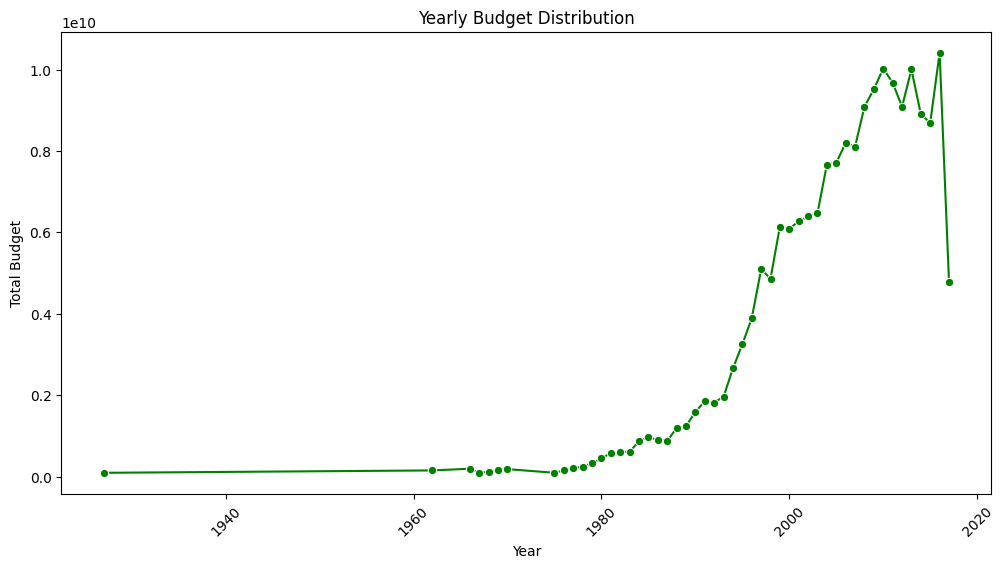

In [279]:
def yearly_budget_trend(yearly_budget: pd.DataFrame):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=yearly_budget, x="release_date", y="budget", marker="o", color="green")
    plt.title("Yearly Budget Distribution")
    plt.xlabel("Year")
    plt.ylabel("Total Budget")
    plt.xticks(rotation=45)
    plt.show()

yearly_budget_trend(yearly_budget.head(50))

Top 10 movies with the most revenue

In [280]:
top_10_revenue = movies_metadata.sort_values(by="revenue", ascending=False).head(10)[["title", "revenue"]]

In [281]:
def top_10_revenue_plot(top_10_revenue):
    plt.figure(figsize=(12, 10))

    # Create the bar plot
    ax = sns.barplot(data=top_10_revenue, y="title", x="revenue", color="skyblue")

    plt.title("Top 10 Movies by Revenue", fontsize=14)
    plt.xlabel("Revenue", fontsize=12)
    plt.ylabel("Movie", fontsize=12)

    # Add value labels to the end of each bar
    for i in ax.containers[0]:
        width = i.get_width()
        # Format large numbers
        if width >= 1_000_000_000:
            label = f"${width/1_000_000_000:.2f}B"
        elif width >= 1_000_000:
            label = f"${width/1_000_000:.2f}M"
        else:
            label = f"${width:,.0f}"
        
        ax.text(width + i.get_width().min() * 0.01, i.get_y() + i.get_height()/2, label, 
                va="center", ha="left", fontsize=10)

    plt.tight_layout()
    plt.show()

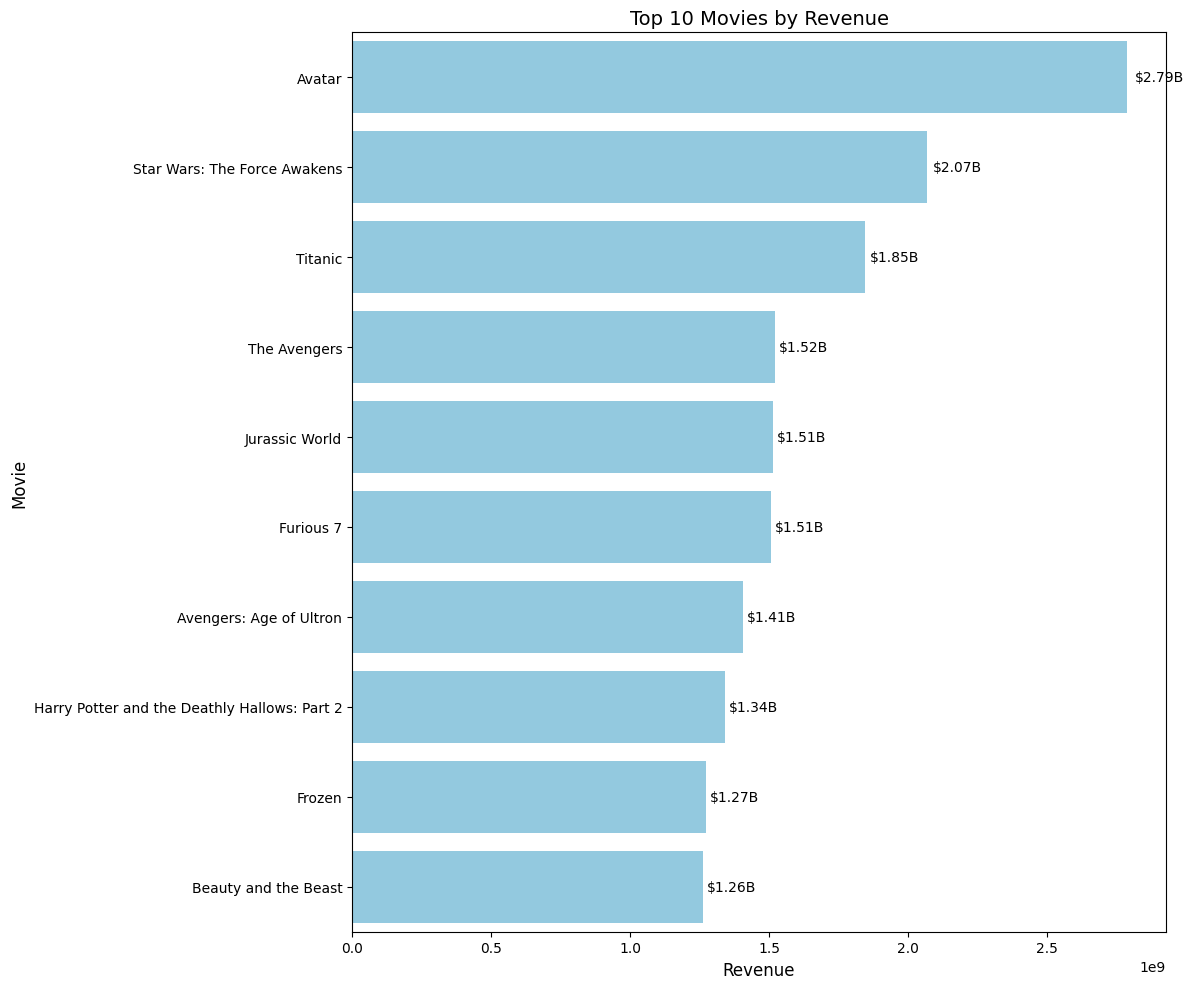

In [282]:
top_10_revenue_plot(top_10_revenue)